# Introduction to fastFMM model fitting

### Gabriel Loewinger, Erjia Cui, Alison W Xin

### Python Conversion: Josh Lawrimore

In [1]:
import numpy as np
import pandas as pd
from rpy2 import robjects as ro

from fast_fmm_rpy2 import fui
from fast_fmm_rpy2.plot_fui import plot_fui


Error importing in API mode: ImportError("dlopen(/Users/lawrimorejg/repos/fast-fmm-rpy2/.venv/lib/python3.11/site-packages/_rinterface_cffi_api.abi3.so, 0x0002): Library not loaded: /Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib\n  Referenced from: <20FB70DB-7E84-3375-A520-E0350E06C060> /Users/lawrimorejg/repos/fast-fmm-rpy2/.venv/lib/python3.11/site-packages/_rinterface_cffi_api.abi3.so\n  Reason: tried: '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file)")
Trying to import in ABI mode.


## Introduction

`fastFMM` is a toolkit for fitting functional mixed models (FMMs) and implements the fast univariate inference (FUI) method proposed in [Cui et al. (2022)](https://doi.org/10.1080/10618600.2021.1950006) and further described in [Loewinger et al. (2024)](https://doi.org/10.7554/eLife.95802.2) and Xin et al. (2025). In this vignette, we provide a tutorial on how to use the `fui` function to fit non-concurrent and concurrent FMMs. 

## Installation

**The fui function supporting concurrency is currently under development** While `fastFMM` is available on CRAN, the development version of the package can be downloaded from [GitHub](https://github.com/awqx/fastFMM):

```R
if (!require("devtools")) install.packages("devtools")
devtools::install_github("awqx/fastFMM", dependencies = TRUE)
```

**WARNING: compiling the dependencies of the dev version of fastFMM takes a significant amount of time and specification of compilers, see `Installing using Conda/Mamba environment` section of main `README.md` for more information.

### Fast univariate inference (FUI)

Let $Y_{i, j} (s)$ be observations of multi-level/longitudinal functional data on the compact functional domain $\mathcal{S} = \{s_1, s_2, \dots, s_L\}$. Let $i = 1, 2, ..., I$ be the index of the subject and $j = 1, 2, ..., J_i$ be the index of longitudinal visit at time $t_{i, j}$. For each visit of each subject, we observe the fixed effects column vector $\mathbf{X}_{i, j} = [X_{i, j, 1}, X_{i, j, 2}, \dots, X_{i, j, p}]^T \in \mathbb{R}^p$ and the random effects column vector $\mathbf{Z}_{ij} = [Z_{i, j, 1}, Z_{i, j, 2}, ..., Z_{i, j, q}]^T \in \mathbb{R}^q$. Let $g(\cdot)$ be some pre-specified link function and $EF(\cdot)$ be some exponential family distribution. A longitudinal function-on-scalar regression model has the form

$$
\begin{aligned} 
  & Y_{ij}(s) \sim EF\{\mu_{ij}(s)\}, \\
  & g\{\mu_{ij}(s)\} = \eta_{ij}(s) = \boldsymbol{X}_{ij}^T\boldsymbol{\beta}(s) + \boldsymbol{Z}_{ij}^T\boldsymbol{u}_i(s),
\end{aligned} 
$$ 

referred to as a functional mixed model (FMM) in the functional data analysis (FDA) literature. Many statistical methods have been proposed to fit FMMs, and generally fall into two categories: joint methods and marginal methods. FUI is a marginal method that is computationally fast and achieves similar estimation accuracy compared with the state-of-the-art joint method, such as the `refund::pffr()` function.

FUI consists of the following three steps:

1. *Fit univariate models*. Fit separate linear mixed models at every point along the functional domain $\mathcal{S}$. That is, at each location $s_l \in \mathcal{S}, l = 1, 2, ..., L$,  we fit a pointwise generalized linear mixed model (GLMM) of the form
$$
\begin{aligned} 
  & Y_{i, j}(s_l) \sim EF\{\mu_{i,j}(s_l)\}, \\
  & g\{\mu_{i, j}(s_l)\} = \eta_{i,j}(s_l) = \boldsymbol{X}_{i,j}^T\boldsymbol{\beta}(s_l) + \boldsymbol{Z}_{i,j}^T\boldsymbol{u}_i(s_l),
\end{aligned}
$$ 
where $\boldsymbol{\beta}(s_l)$ is a $p \times 1$ dimensional vector of fixed effects and $\boldsymbol{u}_i(s_l)$ is a $q \times 1$ dimensional vector of random effects. Let $\boldsymbol{\tilde{\beta}}(s_1), \boldsymbol{\tilde{\beta}}(s_2), ..., \boldsymbol{\tilde{\beta}}(s_L)$ be the estimates of fixed effects from $L$ separate univariate GLMMs.

2. *Smooth coefficients*. Using penalized splines, aggregate and smooth the coefficient estimates $\boldsymbol{\tilde{\beta}}(s_1), \boldsymbol{\tilde{\beta}}(s_2), ..., \boldsymbol{\tilde{\beta}}(s_L)$ to produce estimates $\{\boldsymbol{\hat{\beta}}(s), s \in \mathcal{S}\}$. 
3. *Build pointwise and joint confidence intervals*. Combine the within-timepoint variance and the between-timepoint covariance to create confidence bands around the smoothed estimates from Step 2. For Gaussian data, we can obtain these estimates analytically. For other distributions, we implement cluster bootstrap. 

FUI decomposes the complex correlation structure into longitudinal and functional directions, allowing for a computationally efficient estimation procedure. [Cui et al. (2022)](https://doi.org/10.1080/10618600.2021.1950006) contains additional details on the theoretical derivation of the analytic and bootstrap approach to model fitting. We also extend the analytic approach to general random effects specifications in [Loewinger et al. (2024)](https://doi.org/10.7554/eLife.95802.2) and concurrent model fitting in Xin et al. (2025).

### Additional references

We describe applications of `fastFMM` to photometry signal analysis in [Loewinger et al. (2024)](https://doi.org/10.7554/eLife.95802.2) and Xin et al. (2025). In Loewinger et al. (2024), we detailed advantages of functional mixed modeling over conventional photometry analysis methods, including the ability to generate hypothesis tests at every trial timepoint, incorporate the photometry signal for every animal and trial, capture nested effects, and compare temporal dynamics. In Xin et al. (2025), we focused on the extension of the FUI method to concurrent FMMs and described particular cases where concurrent FMMs produce more interpretable coefficient estimates.

## Data organization

The function `fastFMM::fui` requires that data be presented in a long format, i.e., with columns corresponding to locations on the functional domain $1, 2, \dots, L$ and with rows corresponding to longitudinal observations $t_{i, j}$. For example, within `fastFMM`, we provide the pre-formatted dataset `lick`, sourced from [Jeong et al. (2022)](https://doi.org/10.1126/science.abq6740). 

```
lick <- fastFMM::lick
```

### General formatting

The columns `id, session, trial` correspond to trial-level covariates. The functional outcome of `photometry` is stored in the columns `photometry_1, photometry_2, ..., photometry_43` and the functional covariate `lick` is stored in the columns `lick_1, lick_2, ..., lick_43`. The `lick` dataset importable through `fastFMM` is a downsampled version of the original, containing half as many trials and half as many within-trial timepoints.

Below is an example of importing the lick data into a Pandas dataframe from the fastFMM package:

In [2]:
# load in the lick data in R
ro.r('lick <- fastFMM::lick')

# convert to a pandas dataframe
with (ro.default_converter + ro.pandas2ri.converter).context():
    lick_df = ro.conversion.rpy2py(ro.r['lick'])
lick_df.head()


,id,session,trial,lick_rate_050,lick_rate_100,lick_rate_150,lick_rate_200,iri,photometry_1,photometry_2,...,lick_34,lick_35,lick_36,lick_37,lick_38,lick_39,lick_40,lick_41,lick_42,lick_43
1,HJ-FP-M2,1,2,0.0,0.0,0.666667,2.0,30.896,0.452668,-0.350987,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
2,HJ-FP-M2,1,3,0.0,0.0,0.666667,2.5,14.353,-0.780029,-1.680367,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
3,HJ-FP-M2,1,4,0.0,0.0,0.000000,0.0,6.101,-0.536258,1.023902,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,HJ-FP-M2,1,5,2.0,4.0,6.000000,6.0,10.841,1.782039,1.607018,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,HJ-FP-M2,1,6,0.0,0.0,2.666667,4.5,5.346,4.149711,4.267389,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


Below is an example of how to store the photometry signal and the binary lick events as lists within a dataframe for easier indexing:

In [3]:
lick_mat = lick_df.loc[:, 'lick_1':'lick_43'].to_numpy().astype(np.int8)

# Select columns photometry_1 through photometry_43
photometry_mat = (lick_df.loc[:, 'photometry_1':'photometry_43']
                  .to_numpy()
                  .astype(np.float32))

# Create a new DataFrame similar to lick_asis
lick_asis = pd.DataFrame({
    'id': lick_df['id'],
    'trial': lick_df['trial'],
    'session': lick_df['session'],
    'lick': list(lick_mat),
    'photometry': list(photometry_mat)
})
lick_asis.head()


,id,trial,session,lick,photometry
1,HJ-FP-M2,2,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.45266753, -0.35098672, -0.68340844, -0.4131..."
2,HJ-FP-M2,3,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.7800289, -1.6803674, -2.0050824, -1.420795..."
3,HJ-FP-M2,4,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.5362578, 1.0239016, 2.107521, 2.7641423, 2..."
4,HJ-FP-M2,5,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.7820389, 1.6070178, 0.87225837, -0.22539273..."
5,HJ-FP-M2,6,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[4.149711, 4.2673893, 4.048213, 3.588518, 2.91..."


In the remainder of this tutorial, we will continue to use the original data frame `lick`. 

### Scalar covariates

In this dataset, we calculated `lick_rate_NNN` as an example trial-specific behavioral summary. The covariate `lick_rate_NNN` is the average licking rate in the `NNN` hundredths of seconds after the reward is delivered. E.g., `lick_rate_050` is the average licking rate 0.5 seconds after reward delivery. We provide calculated lick rates for four different time periods (0.5, 1.0, 1.5, and 2.0 seconds). We also provide the covariate `iri`, which corresponds to the inter-reward interval, though we do not model with it in this vignette.

```{r see scalars, echo = F}
knitr::kable(lick[1:3, 1:7])
```

### Functional covariates

Below is an excerpt from `lick`, ignoring the columns containing scalar trial-specific covariates.

In [4]:
# Select specific columns
subset = lick_df.loc[:, 'id':'trial'].join(
    lick_df.loc[:, 'photometry_1':'photometry_3']
).join(
    lick_df.loc[:, 'lick_1':'lick_3']
)

# Take the first 5 rows
subset_head = subset.head(5)
subset_head


,id,session,trial,photometry_1,photometry_2,photometry_3,lick_1,lick_2,lick_3
1,HJ-FP-M2,1,2,0.452668,-0.350987,-0.683408,0.0,0.0,0.0
2,HJ-FP-M2,1,3,-0.780029,-1.680367,-2.005082,0.0,0.0,0.0
3,HJ-FP-M2,1,4,-0.536258,1.023902,2.107521,0.0,0.0,0.0
4,HJ-FP-M2,1,5,1.782039,1.607018,0.872258,0.0,0.0,0.0
5,HJ-FP-M2,1,6,4.149711,4.267389,4.048213,0.0,0.0,0.0


The data frame `lick` has $N = \sum_{i = 1}^I n_i$ rows, where $n_i$ is the number of repeated measures observations of subject/cluster $i$. The first three columns of the dataset include the covariates subject ID (`id`), session number (`session`), and trial number (`trial`). The functional outcome and covariate (`photometry` and `lick`, respectively) are stored in $L$ columns each, where $L$ is the size of the functional domain. The prefixes `photometry` and `lick` are arbitrary and can be replaced with any convenient outcome name. However, because `fastFMM::fui` uses initial string matching to find functional outcome and covariate columns, the identifying prefix substring should be unique and not shared with any other columns. Furthermore, `fastFMM::fui` assumes any functional columns are ordered from left to right. 

## Model-fitting

Unless otherwise specified, `fastFMM::fui()` assumes a Gaussian family and provides inference based on an analytic form. To bootstrap confidence intervals, set the argument `analytic = FALSE`. The number of bootstrap replicates can be set with the argument `boot`, which defaults to `boot = 500`. 

Both analytic and bootstrap inference can be sped up by parallelizing the univariate model-fitting with `parallel = TRUE`. For analytic variance calculation, `parallel = TRUE` also parallelizes the calculation of the fixed effects covariance matrix. The number of cores is calculated as `round(parallel::detectCores() * 0.75)` by default but can also be specified in `n_cores`. To speed up model comparisons, variance calculation can be skipped entirely by setting `var = FALSE`. `AIC` and `BIC` will still be naturally outputted in the model objects. 

`fastFMM::fui()` uses the same mixed model formula structure as `lme4::lmer()`. The `family` argument is the standard GLM family from `R` `stats::glm()`. `fastFMM` allows for any family in the `glmer()` and `lmer()` functions offered by the `lme4` package. For any complex random effect structures (e.g., nested) or when more than one variable is specified on the right hand side of the `|` symbol in the random effects formula , the column name in the `data` data.frame corresponding to the subject-ID should be specified in the argument `subj_ID` to avoid any confusion. E.g., for a model with the random effect structure `(1 | id / trial)`, we would provide `fui()` with the argument `subj_ID = "id"`. 

Providing a vector of indices of the functional outcome to `argvals` can be used to downsample model-fitting to only a subset of the functional domain. For example, `argvals = seq(from = 1, to = L, by = 3)` analyzes every third point of the functional outcome.

### Non-concurrent FMM fitting

The function `fastFMM::fui` assumes models are non-concurrent by default. We can generate a few candidate models and compare their AIC/BIC as follows:

In [5]:
# rather than reading in a CSV file, we can use the lick data directly from R
ro.r('lick <- fastFMM::lick')

# Random Intercept
mod1 = fui(
    None,
    "photometry ~ lick_rate_050 + (1 | id)",
    var=False,
    silent=True,
    r_var_name='lick'
)

# Random Slope and Intercept
mod2 = fui(
    None,
    "photometry ~ lick_rate_050 + (lick_rate_050 | id)",
    var=False,
    silent=True,
    r_var_name='lick'
)

mod3 = fui(
    None,
    "photometry ~ lick_rate_050 + trial + session + (lick_rate_050 | id)",
    var=False,
    silent=True,
    r_var_name='lick'
)

for i, mod in enumerate([mod1, mod2, mod3]):
    print(f"Model {i+1}:")
    print(mod.getbyname('aic').mean().round(1)[['AIC', 'BIC']])
    print("---------")


Model 1:
AIC    8894.4
BIC    8917.0
dtype: float64
---------
Model 2:
AIC    8840.7
BIC    8874.7
dtype: float64
---------
Model 3:
AIC    8831.0
BIC    8876.3
dtype: float64
---------


Once we select a model (here, we choose Model 3), we can run the full analytic variance calculation by removing `var = FALSE`. We show the results in the section "Plotting models".

In [6]:
lick_rate_050 = fui(
    None,
    "photometry ~ lick_rate_050 + trial + session + (lick_rate_050 | id)",
    r_var_name = 'lick',
    silent = True
)


### Concurrent FMM fitting

To fit a concurrent model, set the argument `concurrent = TRUE`. `fastFMM::fui()` will automatically detect which covariates are functional based on matching their names. We will skip over AIC/BIC calculation for brevity and fit a concurrent model with variance calculation. Importantly, we need to remove the scalar covariates `lick_rate_NNN` before model fitting because their names will interfere with detecting the columns for `lick`. Bootstrapped variance calculation is currently not compatible with concurrent modeling.

In [7]:
# Remove conflicting columns in R
ro.r("lick_ <- dplyr::select(lick, -lick_rate_050:-lick_rate_200)")
lick_conc = fui(
    None,
    "photometry ~ lick + trial + session + (lick | id)",
    r_var_name = 'lick_',
    concurrent = True,
    parallel = True,
    n_cores = 4,
    silent = True
)


## Plotting models

After fitting a model, one can quickly visualize estimates and 95% confidence intervals with the function `fastFMM::plot_fui()`, which works for both non-concurrent and concurrent models. For now, the label for the functional covariates' fixed coefficients correspond to the first covariate name, e.g., `lick_1`. However, the plotted coefficients reflect `lick_1` to `lick_43`.

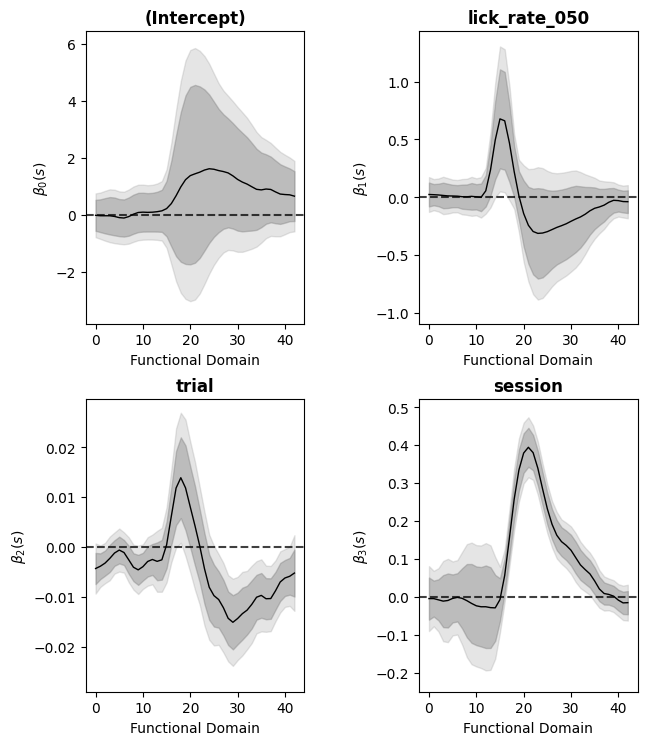

In [8]:
fig = plot_fui(lick_rate_050)
fig.set_size_inches(7, 7.5)


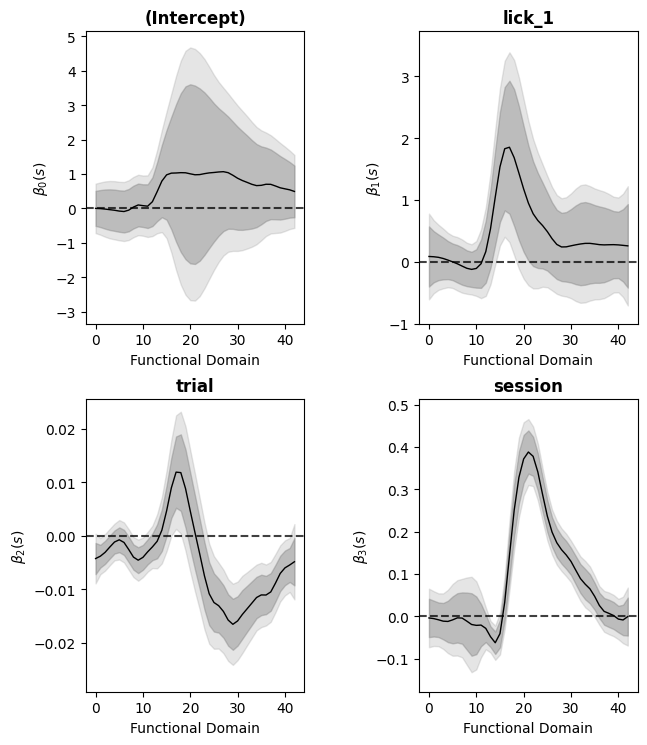

In [9]:
fig = plot_fui(lick_conc)
fig.set_size_inches(7, 7.5)


The x-axis can be translated and scaled with the arguments `x_rescale` and `align_x`. For example, because the x-axis is time in these models, we can rescale the x-values based on sampling rate and align 0 with the trial start time. Furthermore, the number of rows in the plot can be adjusted with `num_row`. Each coefficient's plot can be given a plot title through the vector argument `title_names` and the x-axis can be named through the `xlab` argument.

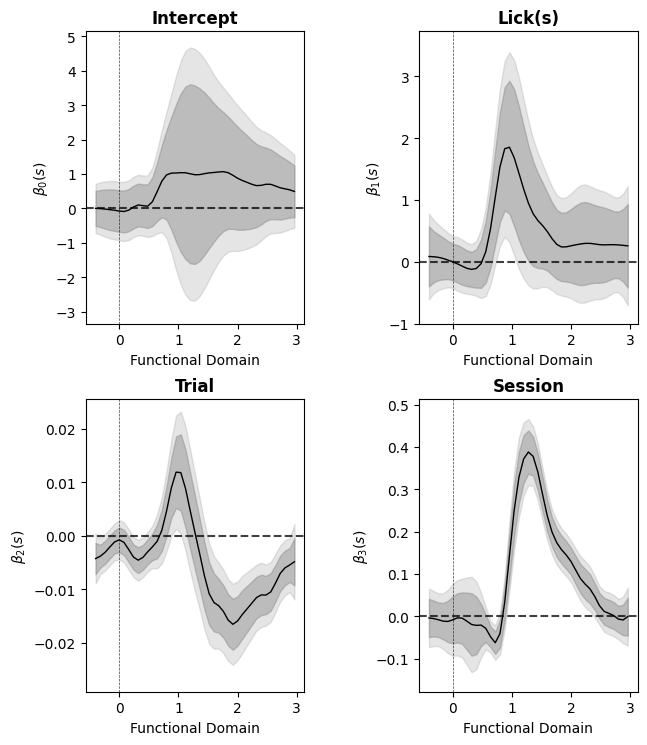

In [10]:
subplot_titles = ["Intercept", "Lick(s)", "Trial", "Session"]
fig, plot_data = plot_fui(
    lick_conc,
    x_rescale=12.5,
    align_x=0.4,
    title_names=subplot_titles,
    num_row=2,
    return_data=True
)
fig.set_size_inches(7, 7.5)


By setting `return_data = True`, the regression coefficient estimates and associated pointwise and joint 95% confidence intervals are outputted from the `plot_fui()` function as a list with $p + 1$ elements, one for each fixed effect and an extra entry for plotting details. Each element in that dictionary (named according to the corresponding fixed effects covariate) is an $L \times L$ data-frame of coefficient estimates and 95% CIs (recall that $L$ is the size of the functional domain).

In [11]:
for key, value in plot_data.items():
    print(key)
    print(value.head(3))
    print(value.shape)
    print("-" * 80)


(Intercept)
   s      beta     lower     upper  lower_joint  upper_joint
1  1  0.000653 -0.508472  0.509778    -0.717775     0.719081
2  2 -0.005110 -0.543495  0.533276    -0.764827     0.754608
3  3 -0.019570 -0.588975  0.549834    -0.823058     0.783918
(43, 6)
--------------------------------------------------------------------------------
lick_1
   s      beta     lower     upper  lower_joint  upper_joint
1  1  0.086234 -0.399415  0.571883    -0.607110     0.779579
2  2  0.082013 -0.331789  0.495815    -0.508758     0.672784
3  3  0.072640 -0.296599  0.441878    -0.454509     0.599789
(43, 6)
--------------------------------------------------------------------------------
trial
   s      beta     lower     upper  lower_joint  upper_joint
1  1 -0.004246 -0.007163 -0.001329    -0.008890     0.000398
2  2 -0.003806 -0.005930 -0.001682    -0.007187    -0.000425
3  3 -0.003088 -0.005240 -0.000937    -0.006513     0.000336
(43, 6)
---------------------------------------------------------

## Advanced Options

### Additional `fui()` arguments

The arguments are passed from the rpy2 fui function directly to the R implementation of fui.

- `silent` (default `FALSE`) controls whether `fui()` outputs the status of the code at each step.
- `nknots_min` (default is $L/2$) sets the number of knots for smoothing.
- `smooth_method` (default `"GCV.Cp"`) sets the method for tuning the smoothing hyperparameter (see `mgcv` package for more information). Options are `GCV` and `GCV.Cp` and `REML`.
- `splines` (default `"tp"`) controls the type of spline. See the `smooth.terms` page from the `mgcv` package for more information. Options include `"tp"`, `"ts"`, `"cr"`, `"cs"` `"te"`, `"ds"`, `"bs"`, `"gp"`, etc. 
- `design_mat` (default `FALSE`) specifies whether the design matrix is returned.
- `residuals` (default `FALSE`) specifies whether the residuals of the univariate GLMM fits are returned.
- **NOT in new fui.R fui function!** `G_return` (default `FALSE`) specifies whether the covariance matrices $G()$ are returned. See [Cui et al. (2022)](https://doi.org/10.1080/10618600.2021.1950006) for more information. 
- `caic` (default `FALSE`) specifies whether [conditional AIC](https://cran.r-project.org/web/packages/cAIC4/cAIC4.pdf) model fit criteria are returned alongside `AIC` and `BIC`.
- `randeffs` (default `FALSE`) specifies whether the BLUP random effect estimates from the univariate GLMM fits are returned. These estimates are directly taken from the output of `lmer()` and `glmer()`.
- `non_neg` (default `non_nef = 0`) specifies whether any non-negativity constraints are placed on variance terms in the Method of Moments estimator for $G()$. We recommend keeping this at its default.
- `MoM` (default `MoM = 1`) specifies the type of Method of Moments estimator for $G()$. `MoM = 2` saves all random effects for the covariance matrix calculation, providing more guaranteed statistical performance at the cost of computational burden. Concurrent models can only use `MoM = 1`.

### Additional `plot_fui()` arguments

-   `num_row` specifies the number of rows the plots will be displayed on. Defaults to $p/2$
-   `align_x` aligns the plot to a certain point on the functional domain and sets this as \`\`0.'' This is particularly useful if time is the functional domain. Defaults to 0.
-   `x_rescale` rescales the x-axis of plots which is especially useful if time is the functional domain and one wishes to, for example, account for the sampling rate. Defaults to 1.
-   `title_names` Allows one to change the titles of the plots. Takes in a vector of strings. Defaults to NULL which uses the variable names in the dataframe for titles.
-   `y_val_lim` is a positive scalar that extends the y-axis by a factor for visual purposes. Defaults to $1.10$. Typically does not require adjustment.
-   `ylim` takes in a $2 \times 1$ vector that specifies limits of the y-axis in plots.
-   `y_scal_orig` a positive scalar that determines how much to reduce the length of the y-axis on the bottom. Typically does not require adjustment. Defaults to 0.05.
-   `xlab` takes in a string for the x-axis title (i.e., the functional domain). Defaults to `Functional Domain`.

## Troubleshooting

- The GitHub repo [nimh-dsst/fast-fmm-rpy2](https://github.com/nimh-dsst/fast-fmm-rpy2/) hosts the rpy2 implimentation of fastFMM. Please use the [nimh-dsst/fast-fmm-rpy2](https://github.com/nimh-dsst/fast-fmm-rpy2/) repo to report Python and rpy2 related issues.
- You are welcome to contact us about `fastFMM` at [gloewinger\@gmail.com](mailto:gloewinger@gmail.com){.email} with any questions or error reports.
- This GitHub account [gloewing/fastFMM](https://github.com/gloewing/fastFMM) hosts the development version of fastFMM and can also be used to submit issues.
- The following warning messages can occur
  - `Warning messages: 1: In sqrt(Eigen\$values) : NaNs produced` -- this can occur when using bootstrap confidence intervals because of the used functional PCA functions. It can be safely ignored.
  - `Warning in checkConv(attr(opt, "derivs"), opt, ctrl = control checkConv: Model failed to converge with max|grad` -- this is a`lme4\` warning message: for data sets with many observations or for models with many parameters (e.g., random effects, fixed effects), convergence warnings are not uncommon. This warning message comes from point-wise mixed model fits. Therefore if these warnings are issued for many points along the functional domain, you may want to consider your fixed or random effect specification. If the warning is only issued for a few points on the functional domain, you may not need to alter your model specification.
  - `Warning in checkConv(attr(opt, "derivs"), opt.par, ctrl = control.checkConv, : Model is nearly unidentifiable: very large eigenvalue: - Rescale variables? Model is nearly unidentifiable: large eigenvalue ratio` -- This is a`lme4`warning message --This warning can frequently be resolved by scaling continuous covariates, for example, with the command`scale()`--For more information on the`lme4\` package, warning messages, model syntax and general mixed modeling information, see: Doug Bates. [lme4: Mixed-effects modeling with R](https://stat.ethz.ch/~maechler/MEMo-pages/lMMwR.pdf) (2022).

## References

Doug Bates. [lme4: Mixed-effects modeling with R](https://stat.ethz.ch/~maechler/MEMo-pages/lMMwR.pdf) (2022).

Erjia Cui, Andrew Leroux, Ekaterina Smirnova, and Ciprian Crainiceanu. [Fast Univariate Inference for Longitudinal Functional Models](https://doi.org/10.1080/10618600.2021.1950006). Journal of Computational and Graphical Statistics (2022).

Huijeong Jeong, Annie Taylor, Joseph R Floeder, Martin Lohmann, Stefan Mihalas, Brenda Wu, Mingkang Zhou, Dennis A Burke, Vijay Mohan K Namboodiri. [Mesolimbic dopamine release conveys causal associations](https://doi.org/10.1126/science.abq6740). Science (2022).

Gabriel Loewinger, Erjia Cui, David Lovinger, Francisco Pereira. [A Statistical Framework for Analysis of Trial-Level Temporal Dynamics in Fiber Photometry Experiments](https://doi.org/10.7554/eLife.95802.2). eLife Neuroscience (2024).

Alison W Xin, Erjia Cui, Francisco Pereira, Gabriel Loewinger. Extending fast functional mixed models to concurrent photometry analysis. biorXiv (2025). 